In [1]:
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T
from tvm import relax
import numpy as np
import IPython
import tvm

In [2]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"],
             B: T.Buffer[(128, 128), "float32"],
             C: T.Buffer[(128, 128), "float32"]):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]
                

In [3]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

In [4]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print(f_timer_before(a_nd, b_nd, c_nd).mean * 1000)

2.1940774000000003


In [5]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j0, j1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j0, k, j1)
    sch.decompose_reduction(block_C, k)
    return sch

In [6]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
IPython.display.Code(sch.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "main"})
        # body
        # with T.block("root")
        for i, j_0 in T.grid(128, 32):
            for j_1_init in T.serial(4):
                with T.block("C_init"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1_init)
                    T.reads()
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.float32(0)
            for k, j_1 in T.grid(128, 4):
                with T.block("C_update"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 4 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(C[vi, vj], A[vi, vk], B[vj, vk])
                    T.writes(C[vi, vj])
                    C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]

In [7]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print(f_timer_after(a_nd, b_nd, c_nd).mean * 1000)

0.4643853


In [8]:
sch.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  l4, l5 = sch.split(loop=l2, factors=[None, 4], preserve_unit_iters=True)
  sch.reorder(l1, l4, l3, l5)
  b6 = sch.decompose_reduction(block=b0, loop=l3)

In [9]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

In [10]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

IPython.display.Code(sch.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "main"})
        # body
        # with T.block("root")
        for i, j_0 in T.grid(128, 64):
            for j_1_init in T.serial(2):
                with T.block("C_init"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 2 + j_1_init)
                    T.reads()
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.float32(0)
            for k, j_1 in T.grid(128, 2):
                with T.block("C_update"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 2 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(C[vi, vj], A[vi, vk], B[vj, vk])
                    T.writes(C[vi, vj])
                    C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]

In [11]:
sch.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)

In [12]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)
print(type(j_factors[0]))
print(sch.trace)

<class 'tvm.tir.expr.Var'>
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])


In [13]:
IPython.display.Code(sch.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "main"})
        # body
        # with T.block("root")
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(A[vi, vk], B[vj, vk])
                T.writes(C[vi, vj])
                with T.init():
                    C[vi, vj] = T.float32(0)
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]

In [14]:
j_0, j_1 = sch.split(loop=j, factors=j_factors)
sch.reorder(i, j_0, k, j_1)

In [15]:
sch.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)

In [16]:
IPython.display.Code(sch.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "main"})
        # body
        # with T.block("root")
        for i, j_0, k, j_1 in T.grid(128, 128, 128, 1):
            with T.block("C"):
                vi = T.axis.spatial(128, i)
                vj = T.axis.spatial(128, j_1 + j_0)
                vk = T.axis.reduce(128, k)
                T.reads(A[vi, vk], B[vj, vk])
                T.writes(C[vi, vj])
                with T.init():
                    C[vi, vj] = T.float32(0)
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]

In [17]:
sch.decompose_reduction(block_C, k)
IPython.display.Code(sch.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "main"})
        # body
        # with T.block("root")
        for i, j_0 in T.grid(128, 128):
            for j_1_init in T.serial(1):
                with T.block("C_init"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_1_init + j_0)
                    T.reads()
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.float32(0)
            for k, j_1 in T.grid(128, 1):
                with T.block("C_update"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_1 + j_0)
                    vk = T.axis.reduce(128, k)
                    T.reads(C[vi, vj], A[vi, vk], B[vj, vk])
                    T.writes(C[vi, vj])
                    C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]

In [18]:
def random_search(mod: IRModule, num_trials=5):
    best_result = None
    best_sch = None
    
    for i in range(num_trials):
        sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
        lib = tvm.build(sch.mod, target='llvm')
        f_timer_after = lib.time_evaluator('main', tvm.cpu())
        result = f_timer_after(a_nd, b_nd, c_nd).mean
        
        print("==== Attempt %d, time-cost: %.3f ms ====" %(i, result * 1000))
        print(sch.trace)
        
        if best_result is None or result < best_result:
            best_result = result
            best_sch = sch
            
    return best_sch

sch = random_search(MyModule)

==== Attempt 0, time-cost: 0.466 ms ====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)
==== Attempt 1, time-cost: 0.362 ms ====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)
==== Attempt 2, time-cost: 0.355 ms ====
# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.

In [19]:
sch.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  l1, l2, l3 = sch.get_loops(block=b0)
  v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
  l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
  sch.reorder(l1, l6, l3, l7)
  b8 = sch.decompose_reduction(block=b0, loop=l3)

In [20]:
IPython.display.Code(sch.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "main"})
        # body
        # with T.block("root")
        for i, j_0 in T.grid(128, 16):
            for j_1_init in T.serial(8):
                with T.block("C_init"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 8 + j_1_init)
                    T.reads()
                    T.writes(C[vi, vj])
                    C[vi, vj] = T.float32(0)
            for k, j_1 in T.grid(128, 8):
                with T.block("C_update"):
                    vi = T.axis.spatial(128, i)
                    vj = T.axis.spatial(128, j_0 * 8 + j_1)
                    vk = T.axis.reduce(128, k)
                    T.reads(C[vi, vj], A[vi, vk], B[vj, vk])
                    T.writes(C[vi, vj])
                    C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vj, vk]

tune_tir

In [21]:
from tvm import meta_schedule as ms

sch_tuned = ms.tune_tir(
    mod=MyModule,
    target='llvm --num-cores=1',
    max_trials_global=64,
    num_trials_per_iter=64,
    space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
    work_dir='./tune_tmp',
    task_name='main'
)

2023-02-08 02:52:53 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,213.2381,19.6696,19.6696,64,Y



Total trials: 64
Total latency (us): 19.6696

2023-02-08 02:52:53 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       213.2381 |      19.6696 |               19.6696 |     64 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 19.6696



In [22]:
sch_meta_tuned = sch_tuned.query_schedule(MyModule, target=tvm.target.Target('llvm'), workload_name='main')
sch_meta_tuned.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  b1 = sch.get_block(name="root", func_name="main")
  sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
  l2, l3, l4 = sch.get_loops(block=b0)
  v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[1, 4, 4, 8])
  l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
  v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[8, 1, 4, 4])
  l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
  v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[64, 2])
  l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
  sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
  b25 = sch.cache_write(block=b0, write_buffer_index=0, stora

In [23]:
IPython.display.Code(sch_meta_tuned.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        C_global = T.alloc_buffer([128, 128], dtype="float32")
        for i_0_j_0_i_1_fused_fused in T.parallel(32):
            for j_1 in T.serial(1):
                for i_2_init, j_2_init, i_3_init in T.grid(4, 4, 8):
                    for j_3_fused_init in T.vectorized(4):
                        with T.block("C_init"):
                            vi = T.axis.spatial(128, i_0_j_0_i_1_fused_fused % 4 * 32 + i_2_init * 8 + i_3_init)
                            vj = T.axis.spatial(128, i_0_j_0_i_1_fused_fused // 4 * 16 + j_1 * 16 + j_2_init * 4 + j_3_fused_init)
                            T.reads()
                            T.writes(C_global[vi, vj])
                            T.block_attr({"meta_schedule.tiling_structure":"SSRSRS"})
                            C_global[vi, vj] = T.float32(0)
                for k_0, i_2, j_2, k_1, i_3 in T.grid(64, 4, 4, 2, 8):
                    for j_3_fused in T.vectorized(4):
                        with T.block("C_update"):
                            vi = T.axis.spatial(128, i_0_j_0_i_1_fused_fused % 4 * 32 + i_2 * 8 + i_3)
                            vj = T.axis.spatial(128, i_0_j_0_i_1_fused_fused // 4 * 16 + j_1 * 16 + j_2 * 4 + j_3_fused)
                            vk = T.axis.reduce(128, k_0 * 2 + k_1)
                            T.reads(C_global[vi, vj], A[vi, vk], B[vj, vk])
                            T.writes(C_global[vi, vj])
                            T.block_attr({"meta_schedule.tiling_structure":"SSRSRS"})
                            C_global[vi, vj] = C_global[vi, vj] + A[vi, vk] * B[vj, vk]
                for ax0 in T.serial(32):
                    for ax1_fused in T.vectorized(16):
                        with T.block("C_global"):
                            v0 = T.axis.spatial(128, i_0_j_0_i_1_fused_fused % 4 * 32 + ax0)
                            v1 = T.axis.spatial(128, i_0_j_0_i_1_fused_fused // 4 * 16 + ax1_fused)
                            T.reads(C_global[v0, v1])
                            T.writes(C[v0, v1])
                            C[v0, v1] = C_global[v0, v1]

In [24]:
lib = tvm.build(sch_meta_tuned.mod, target='llvm')
f_time_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" %(f_time_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.109 ms


In [25]:
from tvm import meta_schedule as ms

sch_tuned = ms.tune_tir(
    mod=MyModule,
    target='llvm --num-cores=1',
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir='./tune_tmp',
    task_name='main'
)

2023-02-08 02:53:11 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,4194304,1,195.0596,21.5027,21.5027,64,Y



Total trials: 64
Total latency (us): 21.5027

2023-02-08 02:53:11 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |       195.0596 |      21.5027 |               21.5027 |     64 |    Y 
------------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 21.5027



In [26]:
sch_meta_tuned = sch_tuned.query_schedule(MyModule, target=tvm.target.Target('llvm'), workload_name='main')
sch_meta_tuned.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="C", func_name="main")
  b1 = sch.get_block(name="root", func_name="main")
  sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
  l2, l3, l4 = sch.get_loops(block=b0)
  v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[1, 4, 4, 8])
  l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
  v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[8, 1, 4, 4])
  l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
  v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[64, 2])
  l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
  sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
  b25 = sch.cache_write(block=b0, write_buffer_index=0, stora

In [27]:
IPython.display.Code(sch_meta_tuned.mod.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def main(A: T.Buffer[(128, 128), "float32"], B: T.Buffer[(128, 128), "float32"], C: T.Buffer[(128, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        # body
        # with T.block("root")
        C_global = T.alloc_buffer([128, 128], dtype="float32")
        for i_0_j_0_i_1_fused_fused in T.parallel(32):
            for j_1 in T.serial(1):
                for i_2_init, j_2_init, i_3_init in T.grid(4, 4, 8):
                    for j_3_fused_init in T.vectorized(4):
                        with T.block("C_init"):
                            vi = T.axis.spatial(128, i_0_j_0_i_1_fused_fused % 4 * 32 + i_2_init * 8 + i_3_init)
                            vj = T.axis.spatial(128, i_0_j_0_i_1_fused_fused // 4 * 16 + j_1 * 16 + j_2_init * 4 + j_3_fused_init)
                            T.reads()
                            T.writes(C_global[vi, vj])
                            T.block_attr({"meta_schedule.tiling_structure":"SSRSRS"})
                            C_global[vi, vj] = T.float32(0)
                for k_0, i_2, j_2, k_1, i_3 in T.grid(64, 4, 4, 2, 8):
                    for j_3_fused in T.vectorized(4):
                        with T.block("C_update"):
                            vi = T.axis.spatial(128, i_0_j_0_i_1_fused_fused % 4 * 32 + i_2 * 8 + i_3)
                            vj = T.axis.spatial(128, i_0_j_0_i_1_fused_fused // 4 * 16 + j_1 * 16 + j_2 * 4 + j_3_fused)
                            vk = T.axis.reduce(128, k_0 * 2 + k_1)
                            T.reads(C_global[vi, vj], A[vi, vk], B[vj, vk])
                            T.writes(C_global[vi, vj])
                            T.block_attr({"meta_schedule.tiling_structure":"SSRSRS"})
                            C_global[vi, vj] = C_global[vi, vj] + A[vi, vk] * B[vj, vk]
                for ax0 in T.serial(32):
                    for ax1_fused in T.vectorized(16):
                        with T.block("C_global"):
                            v0 = T.axis.spatial(128, i_0_j_0_i_1_fused_fused % 4 * 32 + ax0)
                            v1 = T.axis.spatial(128, i_0_j_0_i_1_fused_fused // 4 * 16 + ax1_fused)
                            T.reads(C_global[v0, v1])
                            T.writes(C[v0, v1])
                            C[v0, v1] = C_global[v0, v1]

In [28]:
lib = tvm.build(sch_meta_tuned.mod, target='llvm')
f_time_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" %(f_time_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.038 ms


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


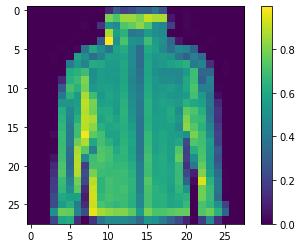

Class:  Coat


In [29]:
import matplotlib.pyplot as plt
import pickle as pkl
import torchvision
import torch
import tvm

test_data = torchvision.datasets.FashionMNIST(root='data', train=False,
                                              transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, lbl = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print('Class: ', class_names[lbl[0]])

params = pkl.load(open("fasionmnist_mlp_params.pkl", 'rb'))
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {
    "w0": tvm.nd.array(params['w0']),
    "b0": tvm.nd.array(params['b0']),
    "w1": tvm.nd.array(params['w1']),
    "b1": tvm.nd.array(params['b1'])
}

In [37]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
                
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]
                
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), relax.TensorStructInfo((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), relax.TensorStructInfo((1, 10), dtype="float32"))
            R.output(out)
        return out
    
    
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)
    

@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray,
               out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)
    
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
ex = relax.vm.build(MyModuleWithParams, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm['main'](data_nd)
print("Pred: %s" %(class_names[np.argmax(nd_res.numpy(), axis=1)[0]]))
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)
print("MyModuleWithParams time-cost: %g ms" %(ftimer(data_nd).mean * 1000))

Pred: Coat
MyModuleWithParams time-cost: 0.154131 ms


In [31]:
mod_linear = IRModule.from_expr(MyModuleMixture['linear0'].with_attr("global_symbol", "main"))
sch_tuned_linear = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    max_trials_global=64,
    num_trials_per_iter=64,
    work_dir='./tune_tmp',
    task_name="main"
)

MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
tuned_sch = sch_tuned_linear.query_schedule(mod_linear, target=tvm.target.Target('llvm'), workload_name='main')
new_func = tuned_sch.mod['main'].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
MyModuleWithParams2.update_func(gv, new_func)

2023-02-08 02:53:37 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,62.4410,3.2163,3.2163,64,Y


2023-02-08 02:53:37 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        62.4410 |       3.2163 |                3.2163 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 3.21635


Total trials: 64
Total latency (us): 3.21635



In [32]:
tuned_sch.trace

# from tvm import tir
def apply_trace(sch: tir.Schedule) -> None:
  b0 = sch.get_block(name="Y", func_name="main")
  b1 = sch.get_block(name="root", func_name="main")
  sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
  l2, l3, l4 = sch.get_loops(block=b0)
  v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[1, 1, 1, 1])
  l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
  v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[16, 1, 2, 4])
  l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
  v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[112, 7])
  l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
  sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
  b25, = sch.get_consumers(block=b0)
  sch.reverse_compute_

In [33]:
IPython.display.Code(MyModuleWithParams2.script(), language="python")

@tvm.script.ir_module
class Module:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i_0_j_0_fused in T.parallel(16, annotations={"pragma_auto_unroll_max_step":T.int64(64), "pragma_unroll_explicit":T.int64(1)}):
            for i_1, j_1 in T.grid(1, 1):
                for i_2_init, j_2_init, i_3_init in T.grid(1, 2, 1):
                    for j_3_fused_init in T.vectorized(4):
                        with T.block("Y_init"):
                            vi = T.axis.spatial(1, i_2_init + i_3_init + i_1)
                            vj = T.axis.spatial(128, i_0_j_0_fused * 8 + j_1 * 8 + j_2_init * 4 + j_3_fused_init)
                            T.reads()
                            T.writes(Y[vi, vj])
                            T.block_attr({"meta_schedule.tiling_structure":"SSRSRS"})
                            Y[vi, vj] = T.float32(0)
                for k_0, i_2, j_2, k_1, i_3 in T.grid(112, 1, 2, 7, 1):
                    for j_3_fused in T.vectorized(4):
                        with T.block("Y_update"):
                            vi = T.axis.spatial(1, i_2 + i_3 + i_1)
                            vj = T.axis.spatial(128, i_0_j_0_fused * 8 + j_1 * 8 + j_2 * 4 + j_3_fused)
                            vk = T.axis.reduce(784, k_0 * 7 + k_1)
                            T.reads(Y[vi, vj], X[vi, vk], W[vj, vk])
                            T.writes(Y[vi, vj])
                            T.block_attr({"meta_schedule.tiling_structure":"SSRSRS"})
                            Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
            for ax0 in T.serial(1):
                for ax1_fused in T.vectorized(8):
                    with T.block("Z"):
                        vi = T.axis.spatial(1, ax0)
                        vj = T.axis.spatial(128, i_0_j_0_fused * 8 + ax1_fused)
                        T.reads(Y[vi, vj], B[vj])
                        T.writes(Z[vi, vj])
                        Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, metadata["relax.expr.Constant"][0], metadata["relax.expr.Constant"][1]), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, metadata["relax.expr.Constant"][2], metadata["relax.expr.Constant"][3]), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [38]:
ex = relax.vm.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)
print("Pred: %s" %(class_names[np.argmax(nd_res.numpy(), axis=1)[0]]))
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)
print("MyModuleWithParams2 time-cost: %g ms" %(ftimer(data_nd).mean * 1000))

Pred: Coat
MyModuleWithParams2 time-cost: 0.0788395 ms
